In [121]:
import pandas as pd
import numpy as np
from point_sampler import PointSampler
import sys
import importlib

importlib.reload(sys.modules['point_sampler'])
from point_sampler import PointSampler

segs = pd.read_csv('segments_by_angle.csv')

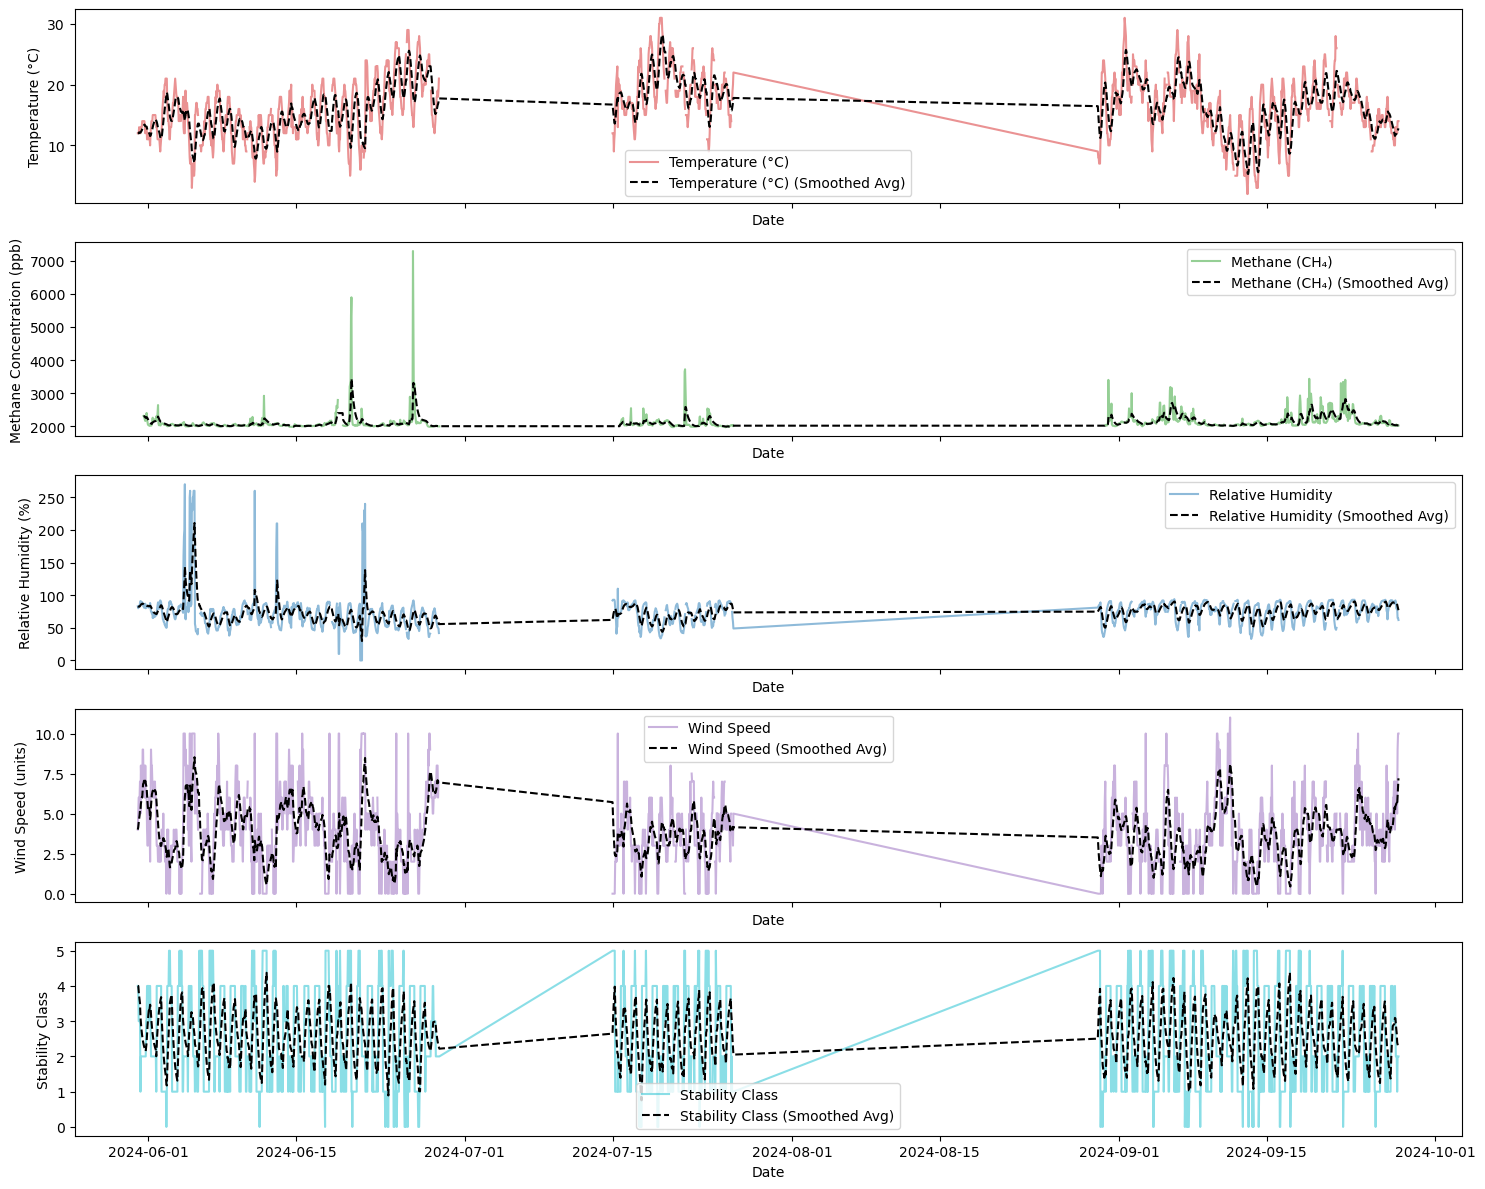

In [122]:
import matplotlib.pyplot as plt
import pandas as pd
from windrose import WindroseAxes

# Load the dataset
file_path = 'data/msr_ch4_met_hrly_310524_270924.csv'
try:
    data = pd.read_csv(file_path)

    # Convert 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

    # Filter data to only include June and July 2024
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
    exit()
except pd.errors.EmptyDataError:
    print(f"Error: The file {file_path} is empty.")
    exit()
except pd.errors.ParserError:
    print(f"Error: The file {file_path} could not be parsed.")
    exit()

# Function to determine Pasquill-Gifford stability class
def determine_stability_class(row):
    hour = row['date'].hour
    wind_speed = row['ws']
    
    if 6 <= hour <= 18:  # Daytime hours (approx. 6 AM to 6 PM)
        if wind_speed < 2:
            return 'A'  # Very Unstable
        elif 2 <= wind_speed <= 5:
            return 'B'  # Moderately Unstable
        else:
            return 'C'  # Slightly Unstable
    else:  # Nighttime hours
        if wind_speed < 2:
            return 'F'  # Stable
        elif 2 <= wind_speed <= 5:
            return 'E'  # Slightly Stable
        else:
            return 'D'  # Neutral

# Apply the function to the dataframe
data['stability_class'] = data.apply(determine_stability_class, axis=1)

# Function to create individual time series subplots with rolling average
def plot_time_series_subplot(ax, x, y, ylabel, label, color, window):
    rolling_avg = y.ewm(span=window, adjust=False).mean()
    ax.plot(x, y, label=label, color=color, alpha=0.5)
    ax.plot(x, rolling_avg, label=f'{label} (Smoothed Avg)', color='black', linestyle='--')
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.legend()

# Function to create combined time series plots
def plot_combined_time_series(data, window=12):
    fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

    # Plot Temperature
    plot_time_series_subplot(axes[0], data['date'], data['temp'], 'Temperature (°C)', 'Temperature (°C)', 'tab:red', window)

    # Plot Methane Concentration
    plot_time_series_subplot(axes[1], data['date'], data['ch4_ppb'], 'Methane Concentration (ppb)', 'Methane (CH₄)', 'tab:green', window)

    # Plot Relative Humidity
    plot_time_series_subplot(axes[2], data['date'], data['rh'], 'Relative Humidity (%)', 'Relative Humidity', 'tab:blue', window)

    # Plot Wind Speed
    plot_time_series_subplot(axes[3], data['date'], data['ws'], 'Wind Speed (units)', 'Wind Speed', 'tab:purple', window)

    # Plot Stability Class
    stability_class_numeric = data['stability_class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5})
    plot_time_series_subplot(axes[4], data['date'], stability_class_numeric, 'Stability Class', 'Stability Class', 'tab:cyan', window)

    plt.tight_layout()
    plt.show()

plot_combined_time_series(data)

0       80.518719
1       81.500611
2       81.500611
3       80.518719
4       80.518719
          ...    
1643    75.163315
1644    75.163315
1645    75.286859
1646    75.163315
1647    75.163315
Name: diffY, Length: 1648, dtype: float64
0      -1532.667318
1      -1590.023640
2      -1590.023640
3      -1532.667318
4      -1532.667318
           ...     
1643   -1307.200124
1644   -1307.200124
1645   -1352.816116
1646   -1307.200124
1647   -1307.200124
Name: diffY, Length: 1648, dtype: float64
0       77.090307
1       80.518719
2       80.518719
3       77.090307
4       77.090307
          ...    
1643    72.755970
1644    72.755970
1645    75.163315
1646    72.755970
1647    72.755970
Name: diffY, Length: 1648, dtype: float64
0       77.090307
1       80.518719
2       80.518719
3       77.090307
4       77.090307
          ...    
1643    72.755970
1644    72.755970
1645    75.163315
1646    72.755970
1647    72.755970
Name: diffY, Length: 1648, dtype: float64
0       77.090307


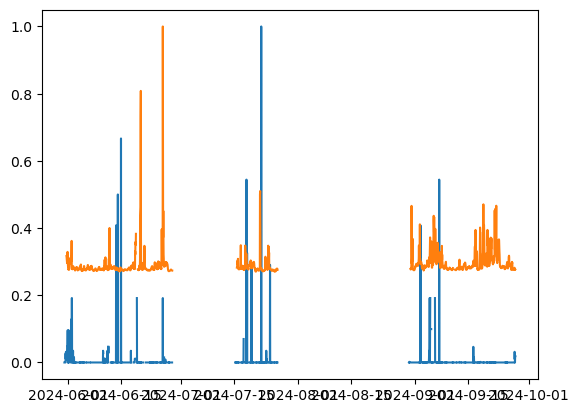

In [123]:
segs = pd.read_csv('segments_by_angle.csv')
origin = (0.1425, 52.2485)
sampler = (0.144343, 52.237111)
origin = tuple(reversed(origin))
sampler = tuple(reversed(sampler))
q=1
total_concentration = np.zeros_like(data['wd'])
segs['diffY'] = segs['Y'].diff()
segs['diffY'] = segs['diffY'].where(segs['diffY'].shift(1) == segs['diffY'], segs['diffY'].shift(1))
for i in range(19):
    current_seg = segs.iloc[i::19]
    data['wd'] = np.round(data['wd'],-1)
    merged = data.merge(current_seg, on='wd',how='left')
    print(merged['diffY'])
    each_line_sample = PointSampler(sampler, 0)
    each_line_sample.add_source(origin, merged['Length']/2, 0)
    merged['downwind'], merged['crosswind']= each_line_sample.get_relative_distances(merged['wd'])
    merged['downwind'] = merged['downwind'] + merged['Y']
    merged['crosswind'] = merged['crosswind'] + merged['Midpoint']
    merged['concentration'] = each_line_sample.conc_at_point(merged['downwind'], merged['crosswind'], merged['ws'],merged['stability_class'],q)
    total_concentration += merged['concentration'] * merged['diffY']
plt.plot(data['date'], total_concentration/np.max(total_concentration))

plt.plot(data['date'], data['ch4_ppb']/np.max(data['ch4_ppb']))


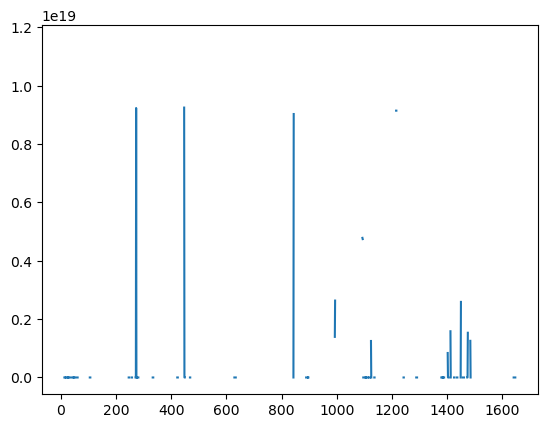

In [124]:
flux = data['ch4_ppb']/total_concentration

plt.plot(flux)
data['total_concentration']=total_concentration
data['flux']=flux


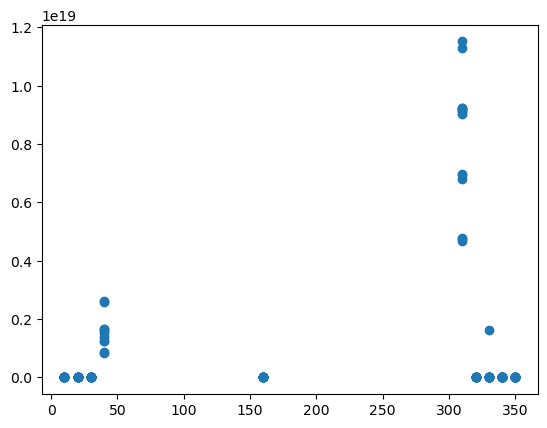

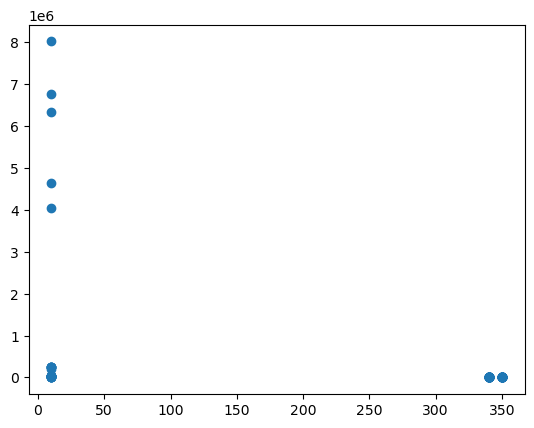

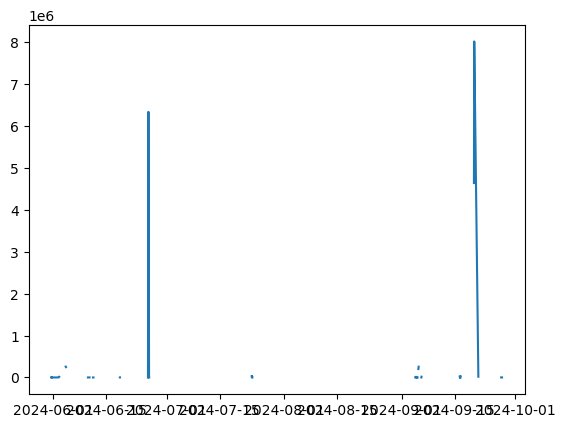

In [126]:
plt.scatter(data['wd'], data['flux'])
data_direction_filtered = data[(data['wd'] < 20) | (data['wd'] > 330)]
plt.show()
plt.scatter(data_direction_filtered['wd'], data_direction_filtered['flux'])
plt.show()
plt.plot(data_direction_filtered['date'], data_direction_filtered['flux'])